In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [28]:
def seed_everything(seed=1234):
    random.seed(seed) # 设置Python内置random模块的种子影响：random.randint(), random.choice(), random.shuffle() 等函数
    os.environ['PYTHONHASHSEED'] = str(seed) # 设置Python哈希种子,作用：确保字典、集合等数据结构的哈希行为一致
    np.random.seed(seed)  # 设置NumPy的随机种子,影响：np.random.rand(), np.random.randint() 等NumPy随机函数
    torch.manual_seed(seed) # 设置PyTorch的CPU随机种子
    torch.cuda.manual_seed(seed) # 设置PyTorch的GPU随机种子,影响PyTorch在GPU上的随机操作（如dropout、初始化等）
    torch.backends.cudnn.deterministic = True # 确保CuDNN使用确定性算法,作用：禁用CuDNN的非确定性算法，确保GPU计算结果可重现代价：可能会稍微降低性能
seed_everything(42)

In [29]:
#Read the dataset 
PATH = './dataset/'
labels = pd.read_csv(PATH+'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:] # 获取出第一列以外所有列的名字
print("Train folder has ", len(os.listdir(PATH+'train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


In [30]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
# 在每个品种组内，基于'id'列计算排名用于标识每个品种内样本的顺序
labels['rank'] = labels.groupby('breed').rank()['id']
# aggfunc='first'：如果有重复，取第一个值，fillna(0)：用0填充缺失值
labels_pivot = labels.pivot_table(index='id', columns='breed', values='target', aggfunc='first').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)
# 120种狗+1 id=121

(8689, 121) (1533, 121)


In [31]:
labels.head(5)

,id,breed,target,rank
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,1.0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,1.0
2,001cdf01b096e06d78e9e5112d419397,pekinese,85,1.0
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15,1.0
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49,1.0


In [32]:
from data.dataset import DogBreedDataset,img_transform
batch_size = 12
num_workers = 4
train_img = DogBreedDataset(PATH+'train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset(PATH+'train/', valid, transform = img_transform['valid'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False)
}


In [33]:
use_cuda = torch.cuda.is_available()


In [34]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

In [35]:
# from mpl_toolkits.axes_grid1 import ImageGrid
# img, label = next(iter(dataloaders['train']))
# print(img.size(), label.size())
# fig = plt.figure(1, figsize=(16, 12))
# grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
# for i in range(img.size()[0]):
#     ax = grid[i]
#     imshow(ax, img[i])

In [36]:
from visualize.plot_loss import plot_multiple_metrics_by_epoch
from utils.train import transfer_train
def multi_model_transfer_learning(models,n_epochs):
    train_losses_list=[]
    valid_losses_list=[]
    train_accuracies_list=[]
    valid_accuracies_list=[]
    models_name=[model.__class__.__name__.lower() for model in models]
    for model in models:
        _,train_losses,valid_losses,train_accuracies,valid_accuracies=transfer_train(model,dataloaders,n_epochs=n_epochs)
        train_losses_list.append(train_losses)
        valid_losses_list.append(valid_losses)
        train_accuracies_list.append(train_accuracies)
        valid_accuracies_list.append(valid_accuracies)
    return train_losses_list,valid_losses_list,train_accuracies_list,valid_accuracies_list,models_name

In [37]:
alexnet = models.alexnet(pretrained=True)
googlenet = models.googlenet(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
from models.SeResnet import se_resnext101
senet101=se_resnext101(pretrained="imagenet")

models_list=[alexnet,googlenet,resnet101,vgg16,densenet121,efficientnet_b0,mobilenet_v2,senet101]
train_losses_list,valid_losses_list,train_accuracies_list,valid_accuracies_list,models_name= multi_model_transfer_learning(models_list,25)

New classification layer moved to GPU
Model already exists, loading from ./model_weight/alexnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/googlenet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/resnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/vgg_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/densenet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/efficientnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/mobilenetv2_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exi

In [38]:
from torchvision.models import vit_b_16,ViT_B_16_Weights

num_classes = 120

# 加载模型，并指定新的类别数，忽略原始的头部权重
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
for param in model.parameters():
    param.requires_grad = False
in_features = model.heads[0].in_features
for layer in model.encoder.layers[-2:]:  # 最后两层
    for param in layer.parameters():
        param.requires_grad = True
# 创建新的分类头
model.heads = nn.Sequential(
    nn.Linear(in_features, num_classes)
)
for param in model.heads.parameters():
    param.requires_grad = True
optimizer = torch.optim.AdamW(model.heads.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()
model.to(device)

from utils.train import train
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    25, dataloaders, model,optimizer, criterion, device
)
train_losses_list.append(train_losses)
valid_losses_list.append(valid_losses)
train_accuracies_list.append(train_accuracies)
valid_accuracies_list.append(valid_accuracies)

models_name.append("vit-base-patch16-224-in21k")    
plot_multiple_metrics_by_epoch(
    train_losses_list, valid_losses_list,
    train_accuracies_list, valid_accuracies_list,
    models_name, n_epochs=25
)


Epoch: 1 	Batch: 1 	Training Loss: 4.889987


KeyboardInterrupt: 

In [ ]:
plot_multiple_metrics_by_epoch(
        train_losses_list, valid_losses_list,\
        train_accuracies_list, valid_accuracies_list,\
        models_name, n_epochs=25
    )

In [ ]:
# 可视化feature map
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE
import torch

from visualize.dimension_reduction_visualize import plot_tsne_features_2d,plot_tsne_features_3d
from utils.feature_extract import extract_features_map
features_array,labels_array=extract_features_map(senet101,dataloaders['valid'],use_cuda=use_cuda,n_samples=1000,layer_name='fc')

开始提取特征...
已处理 10 个样本...
已处理 20 个样本...
已处理 30 个样本...
已处理 40 个样本...
已处理 50 个样本...
已处理 60 个样本...
已处理 70 个样本...
已处理 80 个样本...
已处理 90 个样本...
已处理 100 个样本...
已处理 110 个样本...
已处理 120 个样本...
特征形状: (1533, 2048)
标签形状: (1533,)
唯一标签: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.90 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.34 seconds
===> Running optimization with exaggeration=12.00, lr=127.75 for 250 iterations...
Iteration   50, KL divergence 3.6526, 50 iterations in 0.2702 sec
Iteration  100, KL divergence 3.5927, 50 iterations in 0.1943 sec
Iteration  150, KL divergence 3.5932, 50 iterations in 0.1790 sec
Iteration  200, KL divergence 3.5934, 50 iterations in 0.2095 sec
Iteration  250, KL divergence 3.5927, 50 iterations in 0.2418 sec
   --> Time elapsed: 1.10 seconds
===> Running optimization with exaggeration=1.

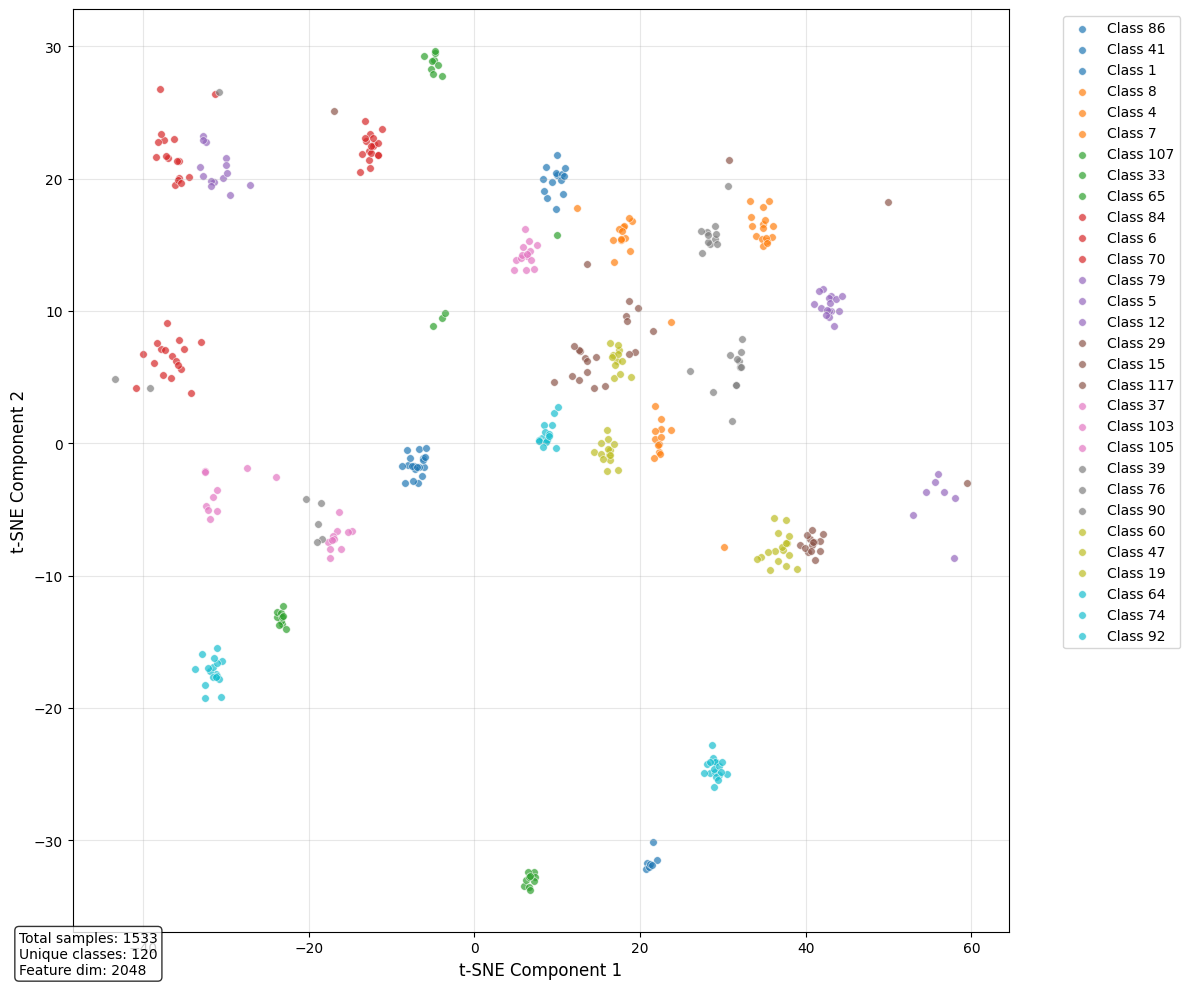

t-SNE可视化完成! 图像保存为: senet101_tsne_features_2d.png


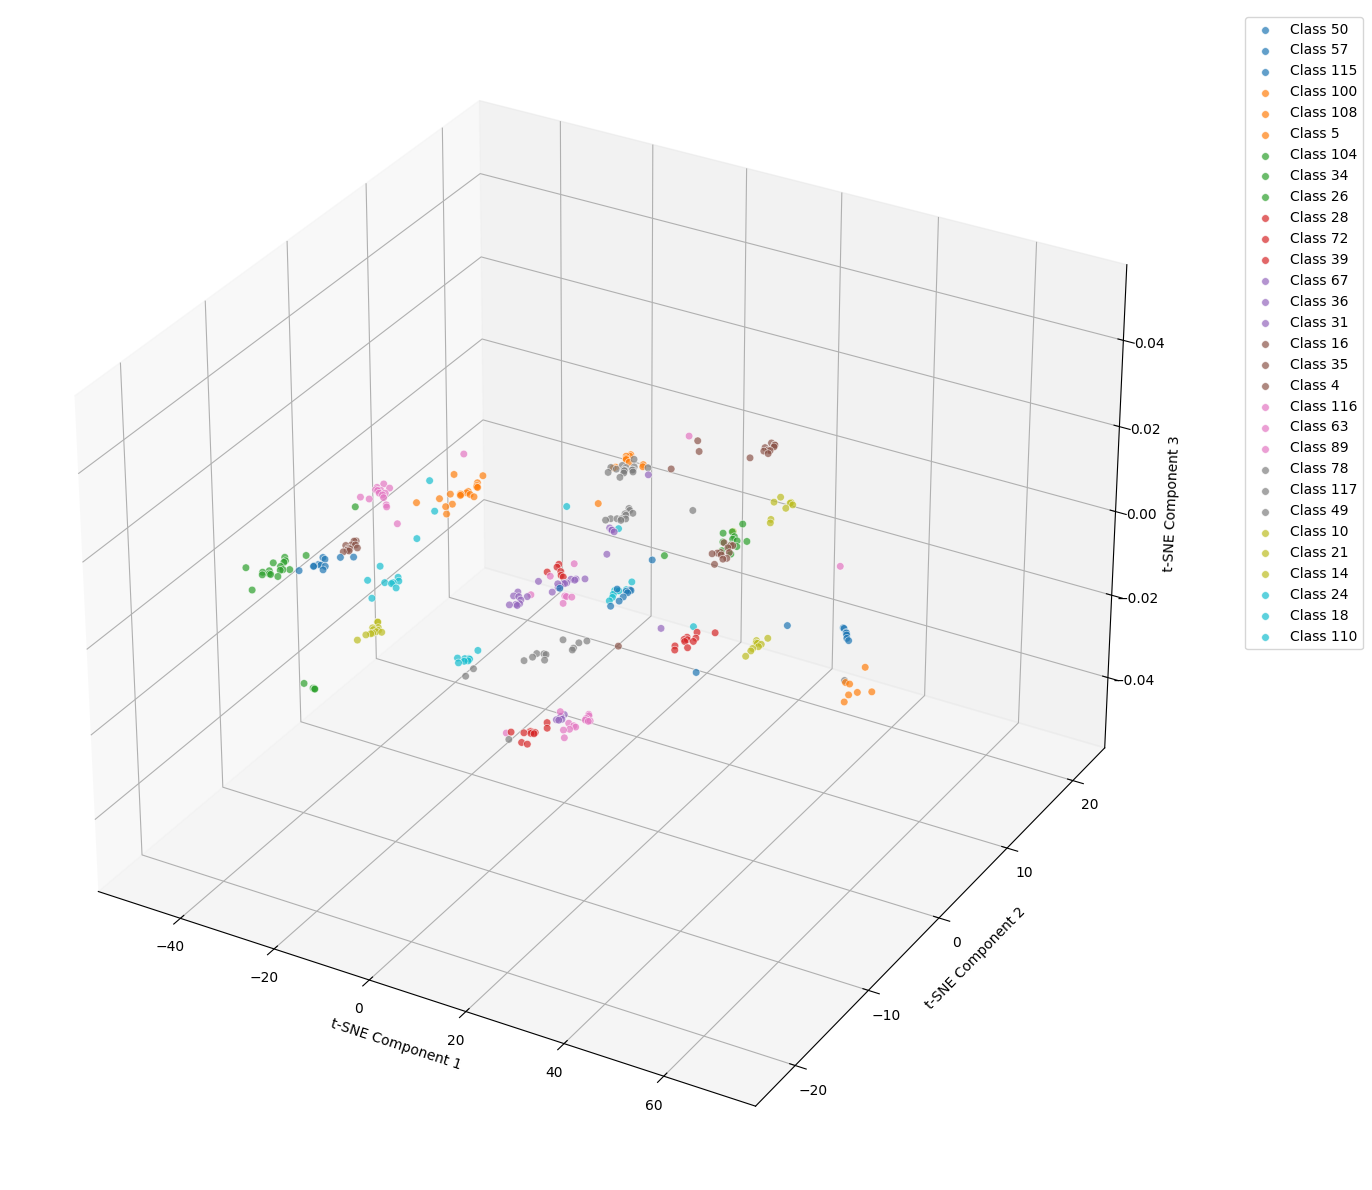

t-SNE可视化完成! 图像保存为: senet101_tsne_features_3d.png


In [ ]:
plot_tsne_features_2d(features_array, labels_array, "senet101")
plot_tsne_features_3d(features_array, labels_array, "senet101")

In [ ]:
# 提取训练集和验证集的特征
print("提取训练集特征...")
features_train, labels_train = extract_features_map(
    senet101, dataloaders['train'], use_cuda=use_cuda, n_samples=1000
)
print("\n提取验证集特征...")
features_valid, labels_valid = extract_features_map(
    senet101, dataloaders['valid'], use_cuda=use_cuda, n_samples=1000
)

提取训练集特征...
开始提取特征...
已处理 10 个样本...
已处理 20 个样本...
已处理 30 个样本...
已处理 40 个样本...
已处理 50 个样本...
已处理 60 个样本...
已处理 70 个样本...
已处理 80 个样本...
已处理 90 个样本...
已处理 100 个样本...
已处理 110 个样本...
已处理 120 个样本...
已处理 130 个样本...
已处理 140 个样本...
已处理 150 个样本...
已处理 160 个样本...
已处理 170 个样本...
已处理 180 个样本...
已处理 190 个样本...
已处理 200 个样本...
已处理 210 个样本...
已处理 220 个样本...
已处理 230 个样本...
已处理 240 个样本...
已处理 250 个样本...
已处理 260 个样本...
已处理 270 个样本...
已处理 280 个样本...
已处理 290 个样本...
已处理 300 个样本...
已处理 310 个样本...
已处理 320 个样本...
已处理 330 个样本...
已处理 340 个样本...
已处理 350 个样本...
已处理 360 个样本...
已处理 370 个样本...
已处理 380 个样本...
已处理 390 个样本...
已处理 400 个样本...
已处理 410 个样本...
已处理 420 个样本...
已处理 430 个样本...
已处理 440 个样本...
已处理 450 个样本...
已处理 460 个样本...
已处理 470 个样本...
已处理 480 个样本...
已处理 490 个样本...
已处理 500 个样本...
已处理 510 个样本...
已处理 520 个样本...
已处理 530 个样本...
已处理 540 个样本...
已处理 550 个样本...
已处理 560 个样本...
已处理 570 个样本...
已处理 580 个样本...
已处理 590 个样本...
已处理 600 个样本...
已处理 610 个样本...
已处理 620 个样本...
已处理 630 个样本...
已处理 640 个样本...
已处理 650 个样本...
已处理 660 个样本..

In [ ]:
# 在特征空间上使用SVM分类
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns
import pandas as pd
def train_svm_on_features(features_train, labels_train, features_test, labels_test, model_name="Model"):
    """
    在提取的特征上训练SVM分类器
    """
    print(f"开始训练SVM分类器...")
    print(f"训练集特征形状: {features_train.shape}, 标签形状: {labels_train.shape}")
    print(f"测试集特征形状: {features_test.shape}, 标签形状: {labels_test.shape}")
    
    # 首先尝试使用线性SVM
    print("训练线性SVM...")
    svm_linear = SVC(kernel='linear', random_state=42)
    svm_linear.fit(features_train, labels_train)
    
    # 在测试集上预测
    y_pred_linear = svm_linear.predict(features_test)
    accuracy_linear = accuracy_score(labels_test, y_pred_linear)
    
    print(f"线性SVM准确率: {accuracy_linear:.4f}")
    print("\n线性SVM分类报告:")
    print(classification_report(labels_test, y_pred_linear))
    
    # 绘制混淆矩阵
    plt.figure(figsize=(60, 50))
    cm = confusion_matrix(labels_test, y_pred_linear)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title(f'{model_name} - 线性SVM混淆矩阵\n准确率: {accuracy_linear:.4f}')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.savefig(f'svm_linear.png', dpi=300, bbox_inches='tight')
    plt.show()
    # 尝试RBF核SVM
    print("\n训练RBF核SVM...")
    svm_rbf = SVC(kernel='rbf', random_state=42)
    svm_rbf.fit(features_train, labels_train)
    
    y_pred_rbf = svm_rbf.predict(features_test)
    accuracy_rbf = accuracy_score(labels_test, y_pred_rbf)
    
    print(f"RBF SVM准确率: {accuracy_rbf:.4f}")
    print("\nRBF SVM分类报告:")
    print(classification_report(labels_test, y_pred_rbf))
    
    # 绘制RBF SVM混淆矩阵
    plt.figure(figsize=(60,50))
    cm_rbf = confusion_matrix(labels_test, y_pred_rbf)
    sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues')
    # plt.title(f'{model_name} - RBF SVM混淆矩阵\n准确率: {accuracy_rbf:.4f}')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.savefig(f'svm_rbf.png', dpi=300, bbox_inches='tight')
    plt.show()
    # 交叉验证评估
    print("\n进行5折交叉验证...")
    cv_scores_linear = cross_val_score(svm_linear, features_train, labels_train, cv=5, scoring='accuracy')
    cv_scores_rbf = cross_val_score(svm_rbf, features_train, labels_train, cv=5, scoring='accuracy')
    
    print(f"线性SVM交叉验证准确率: {cv_scores_linear.mean():.4f} (+/- {cv_scores_linear.std() * 2:.4f})")
    print(f"RBF SVM交叉验证准确率: {cv_scores_rbf.mean():.4f} (+/- {cv_scores_rbf.std() * 2:.4f})")
    
    # 返回最佳模型
    if accuracy_linear >= accuracy_rbf:
        print(f"\n选择线性SVM作为最佳模型 (准确率: {accuracy_linear:.4f})")
        return svm_linear, accuracy_linear, 'linear'
    else:
        print(f"\n选择RBF SVM作为最佳模型 (准确率: {accuracy_rbf:.4f})")
        return svm_rbf, accuracy_rbf, 'rbf'

开始训练SVM分类器...
训练集特征形状: (8689, 2048), 标签形状: (8689,)
测试集特征形状: (1533, 2048), 标签形状: (1533,)
训练线性SVM...
线性SVM准确率: 0.8728

线性SVM分类报告:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.95      1.00      0.97        19
           2       1.00      1.00      1.00        11
           3       0.78      0.93      0.85        15
           4       0.79      0.85      0.81        13
           5       0.56      0.71      0.62         7
           6       0.79      1.00      0.88        15
           7       0.93      1.00      0.97        14
           8       1.00      0.94      0.97        16
           9       0.87      0.95      0.91        21
          10       1.00      0.92      0.96        12
          11       0.83      0.83      0.83        12
          12       0.83      0.94      0.88        16
          13       1.00      0.94      0.97        16
          14       0.82      0.90      0.86        10
       

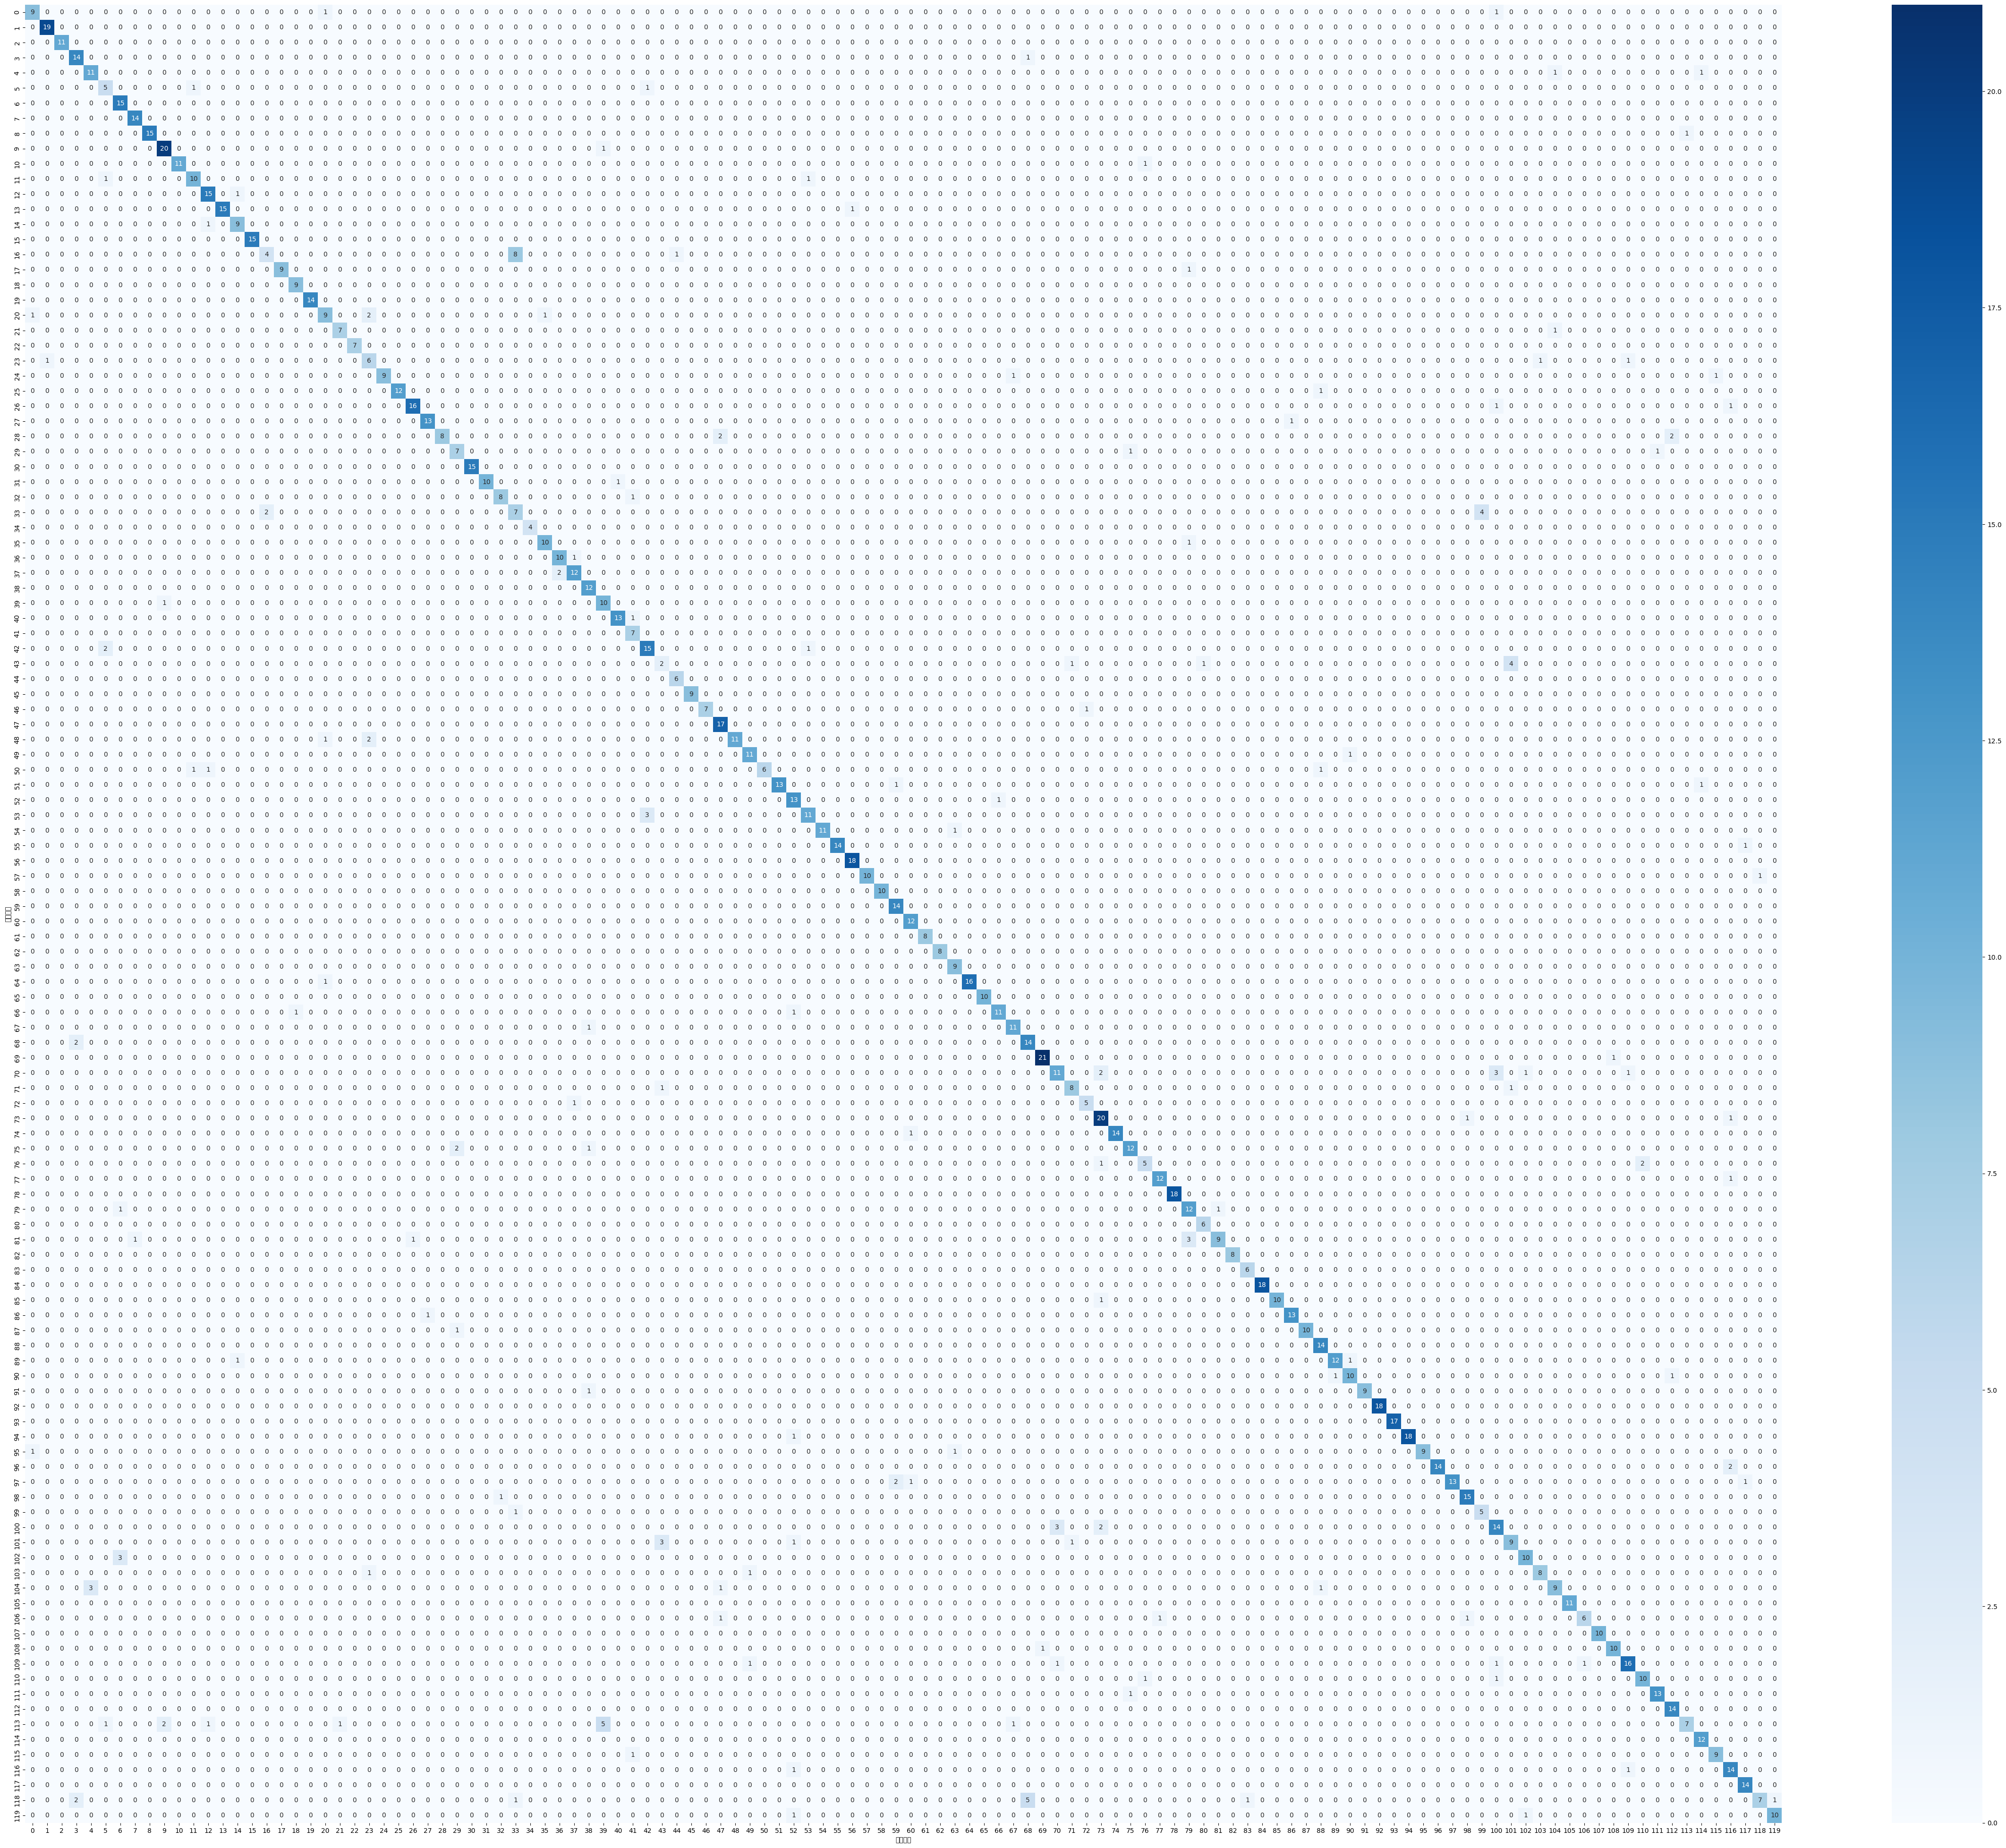


训练RBF核SVM...
RBF SVM准确率: 0.8761

RBF SVM分类报告:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.95      1.00      0.97        19
           2       1.00      1.00      1.00        11
           3       0.78      0.93      0.85        15
           4       0.92      0.85      0.88        13
           5       1.00      0.71      0.83         7
           6       1.00      0.87      0.93        15
           7       0.93      1.00      0.97        14
           8       1.00      0.94      0.97        16
           9       0.77      0.95      0.85        21
          10       1.00      0.92      0.96        12
          11       0.83      0.83      0.83        12
          12       0.89      1.00      0.94        16
          13       1.00      0.94      0.97        16
          14       0.90      0.90      0.90        10
          15       0.94      1.00      0.97        15
          16       0.77      0.77 

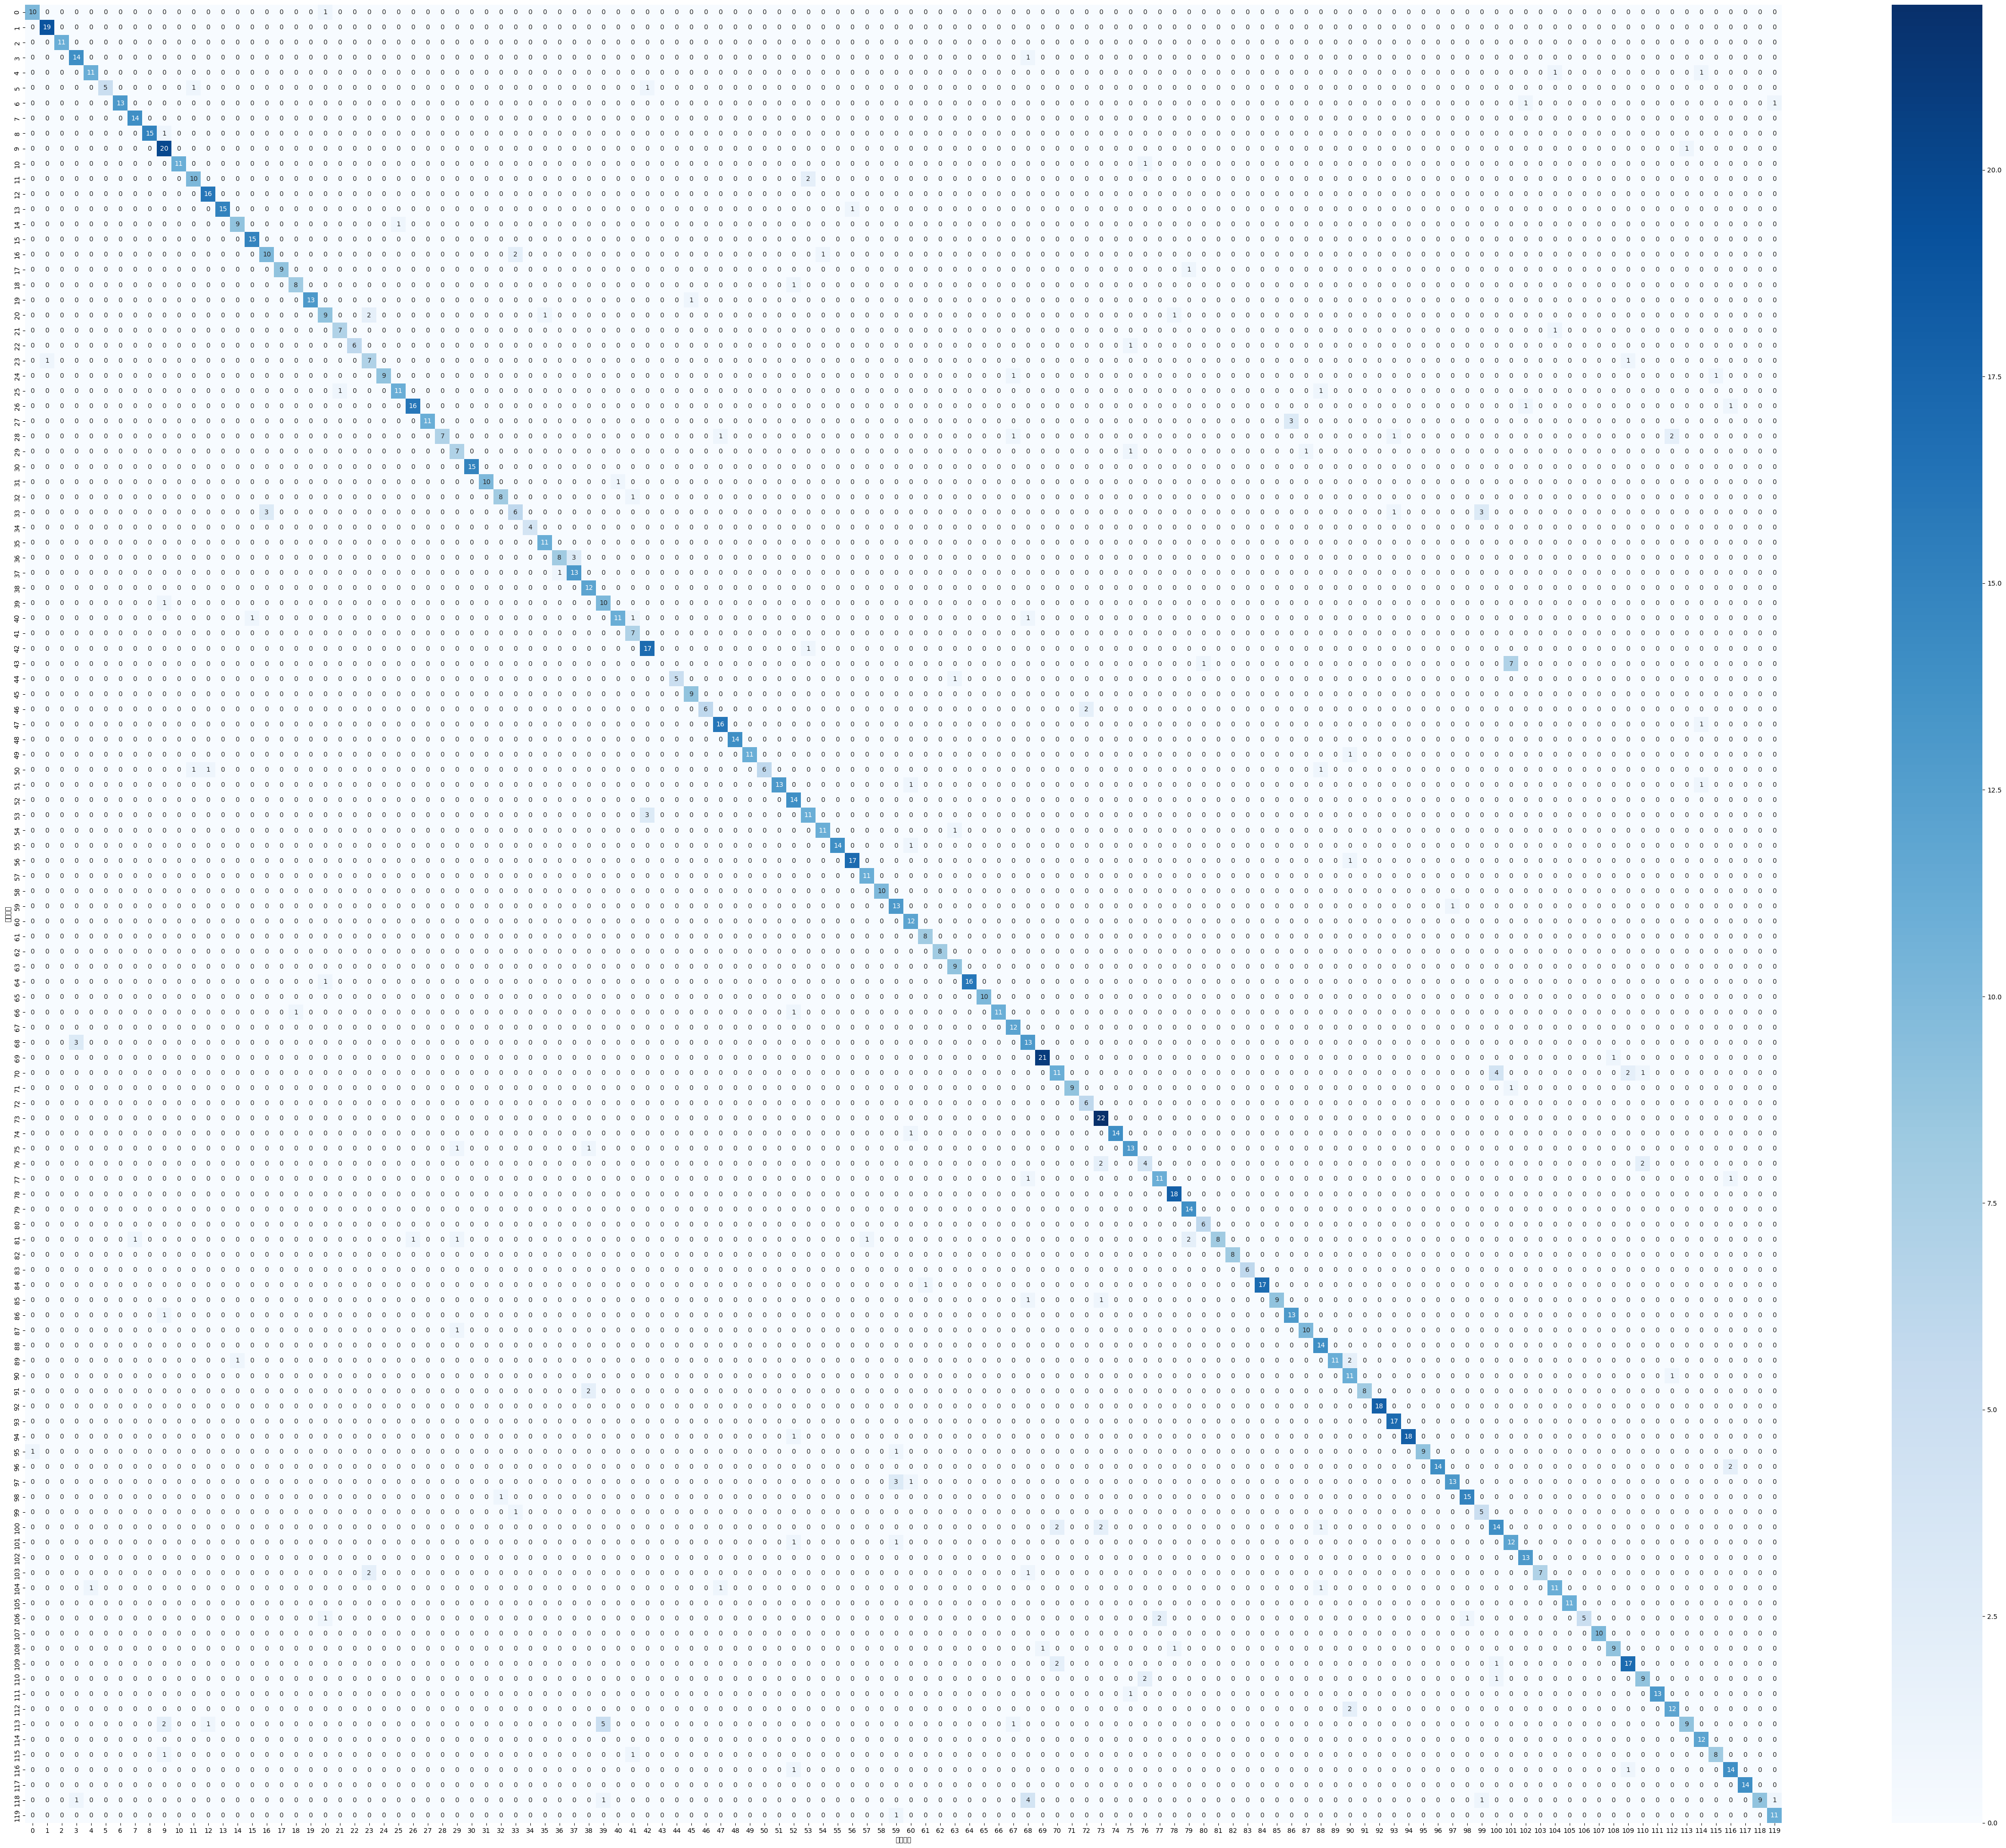


进行5折交叉验证...
线性SVM交叉验证准确率: 0.6764 (+/- 0.0142)
RBF SVM交叉验证准确率: 0.6746 (+/- 0.0218)

选择RBF SVM作为最佳模型 (准确率: 0.8761)


In [ ]:
# 训练SVM分类器
best_svm, best_accuracy, kernel_type = train_svm_on_features(
    features_train, labels_train, features_valid, labels_valid, "SENet101"
)

In [ ]:
# from utils.evaluate import comprehensive_model_evaluation
# results = comprehensive_model_evaluation(
#     model=resnet50,
#     test_loader=dataloaders['valid'],
#     class_names=labelnames,
#     use_cuda=True
# )

# SubmissionAdam

In [ ]:
# submission = pd.read_csv(PATH+'/sample_submission.csv')
# output = pd.DataFrame(index=submission.index, columns=submission.keys() )
# output['id'] = submission['id']
# submission['target'] =  [0] * len(submission)
# #will do this part later :3 

In [ ]:
# import time
# SAMPLE_SUB_PATH=PATH+'/sample_submission.csv'
# TEST_IMG_PATH=PATH+'test/'
# submission_df = pd.read_csv(SAMPLE_SUB_PATH)
# output_df = pd.DataFrame(index=submission_df.index, columns=submission_df.keys() )
# output_df['id'] = submission_df['id']
# submission_df['target'] =  [0] * len(submission_df)

# submission_ds = DogBreedDataset(TEST_IMG_PATH, submission_df,img_transform['test'])

# sub_loader = DataLoader(submission_ds, batch_size=4,
#                         shuffle=False, num_workers=4)

# def test_sumission(model):
#     since = time.time()
#     sub_outputs = []
#     model.train(False)  # Set model to evaluate mode
#     # Iterate over data.
#     for data in sub_loader:
#         # get the inputs
#         inputs, labels = data
#         if use_cuda:
#             inputs, labels = inputs.cuda(), labels.cuda()
#         # forward
#         outputs = model(inputs)
#         _, preds = torch.max(outputs.data, 1)
#         sub_outputs.append(outputs.data.cpu().numpy())

#     sub_outputs = np.concatenate(sub_outputs)
#     for idx,row in enumerate(sub_outputs.astype(float)):
#         sub_outputs[idx] = np.exp(row)/np.sum(np.exp(row))

#     output_df.iloc[:,1:] = sub_outputs
        
#     print()
#     time_elapsed = time.time() - since
#     print('Run complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))

#     return output_df
# # odf = test_sumission(googlenet)
# # odf.to_csv("dogs_id_googlenet.csv", index=False)
# from models.SeResnet import se_resnext101
# import torch

# # 检查可用设备
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"使用设备: {device}")

# # 加载模型
# senet_101 = se_resnext101(num_classes=120, pretrained=None)

# # 加载本地权重
# weight_path = "./model_transfer.pt"
# checkpoint = torch.load(weight_path, map_location='cpu')

# # 处理权重格式
# if isinstance(checkpoint, dict):
#     if 'state_dict' in checkpoint:
#         state_dict = checkpoint['state_dict']
#     elif 'model_state_dict' in checkpoint:
#         state_dict = checkpoint['model_state_dict']
#     else:
#         state_dict = checkpoint
# else:
#     state_dict = checkpoint

# # 加载权重
# senet_101.load_state_dict(state_dict)

# # 关键步骤：将模型移动到GPU
# senet_101 = senet_101.to(device)
# senet_101.eval()

# print("本地权重加载成功！模型已移动到GPU")

# # 使用模型进行预测
# odf = test_sumission(senet_101)
# odf.to_csv("dogs_id_seresnet101.csv", index=False)

文本特征形状： torch.Size([840, 512])


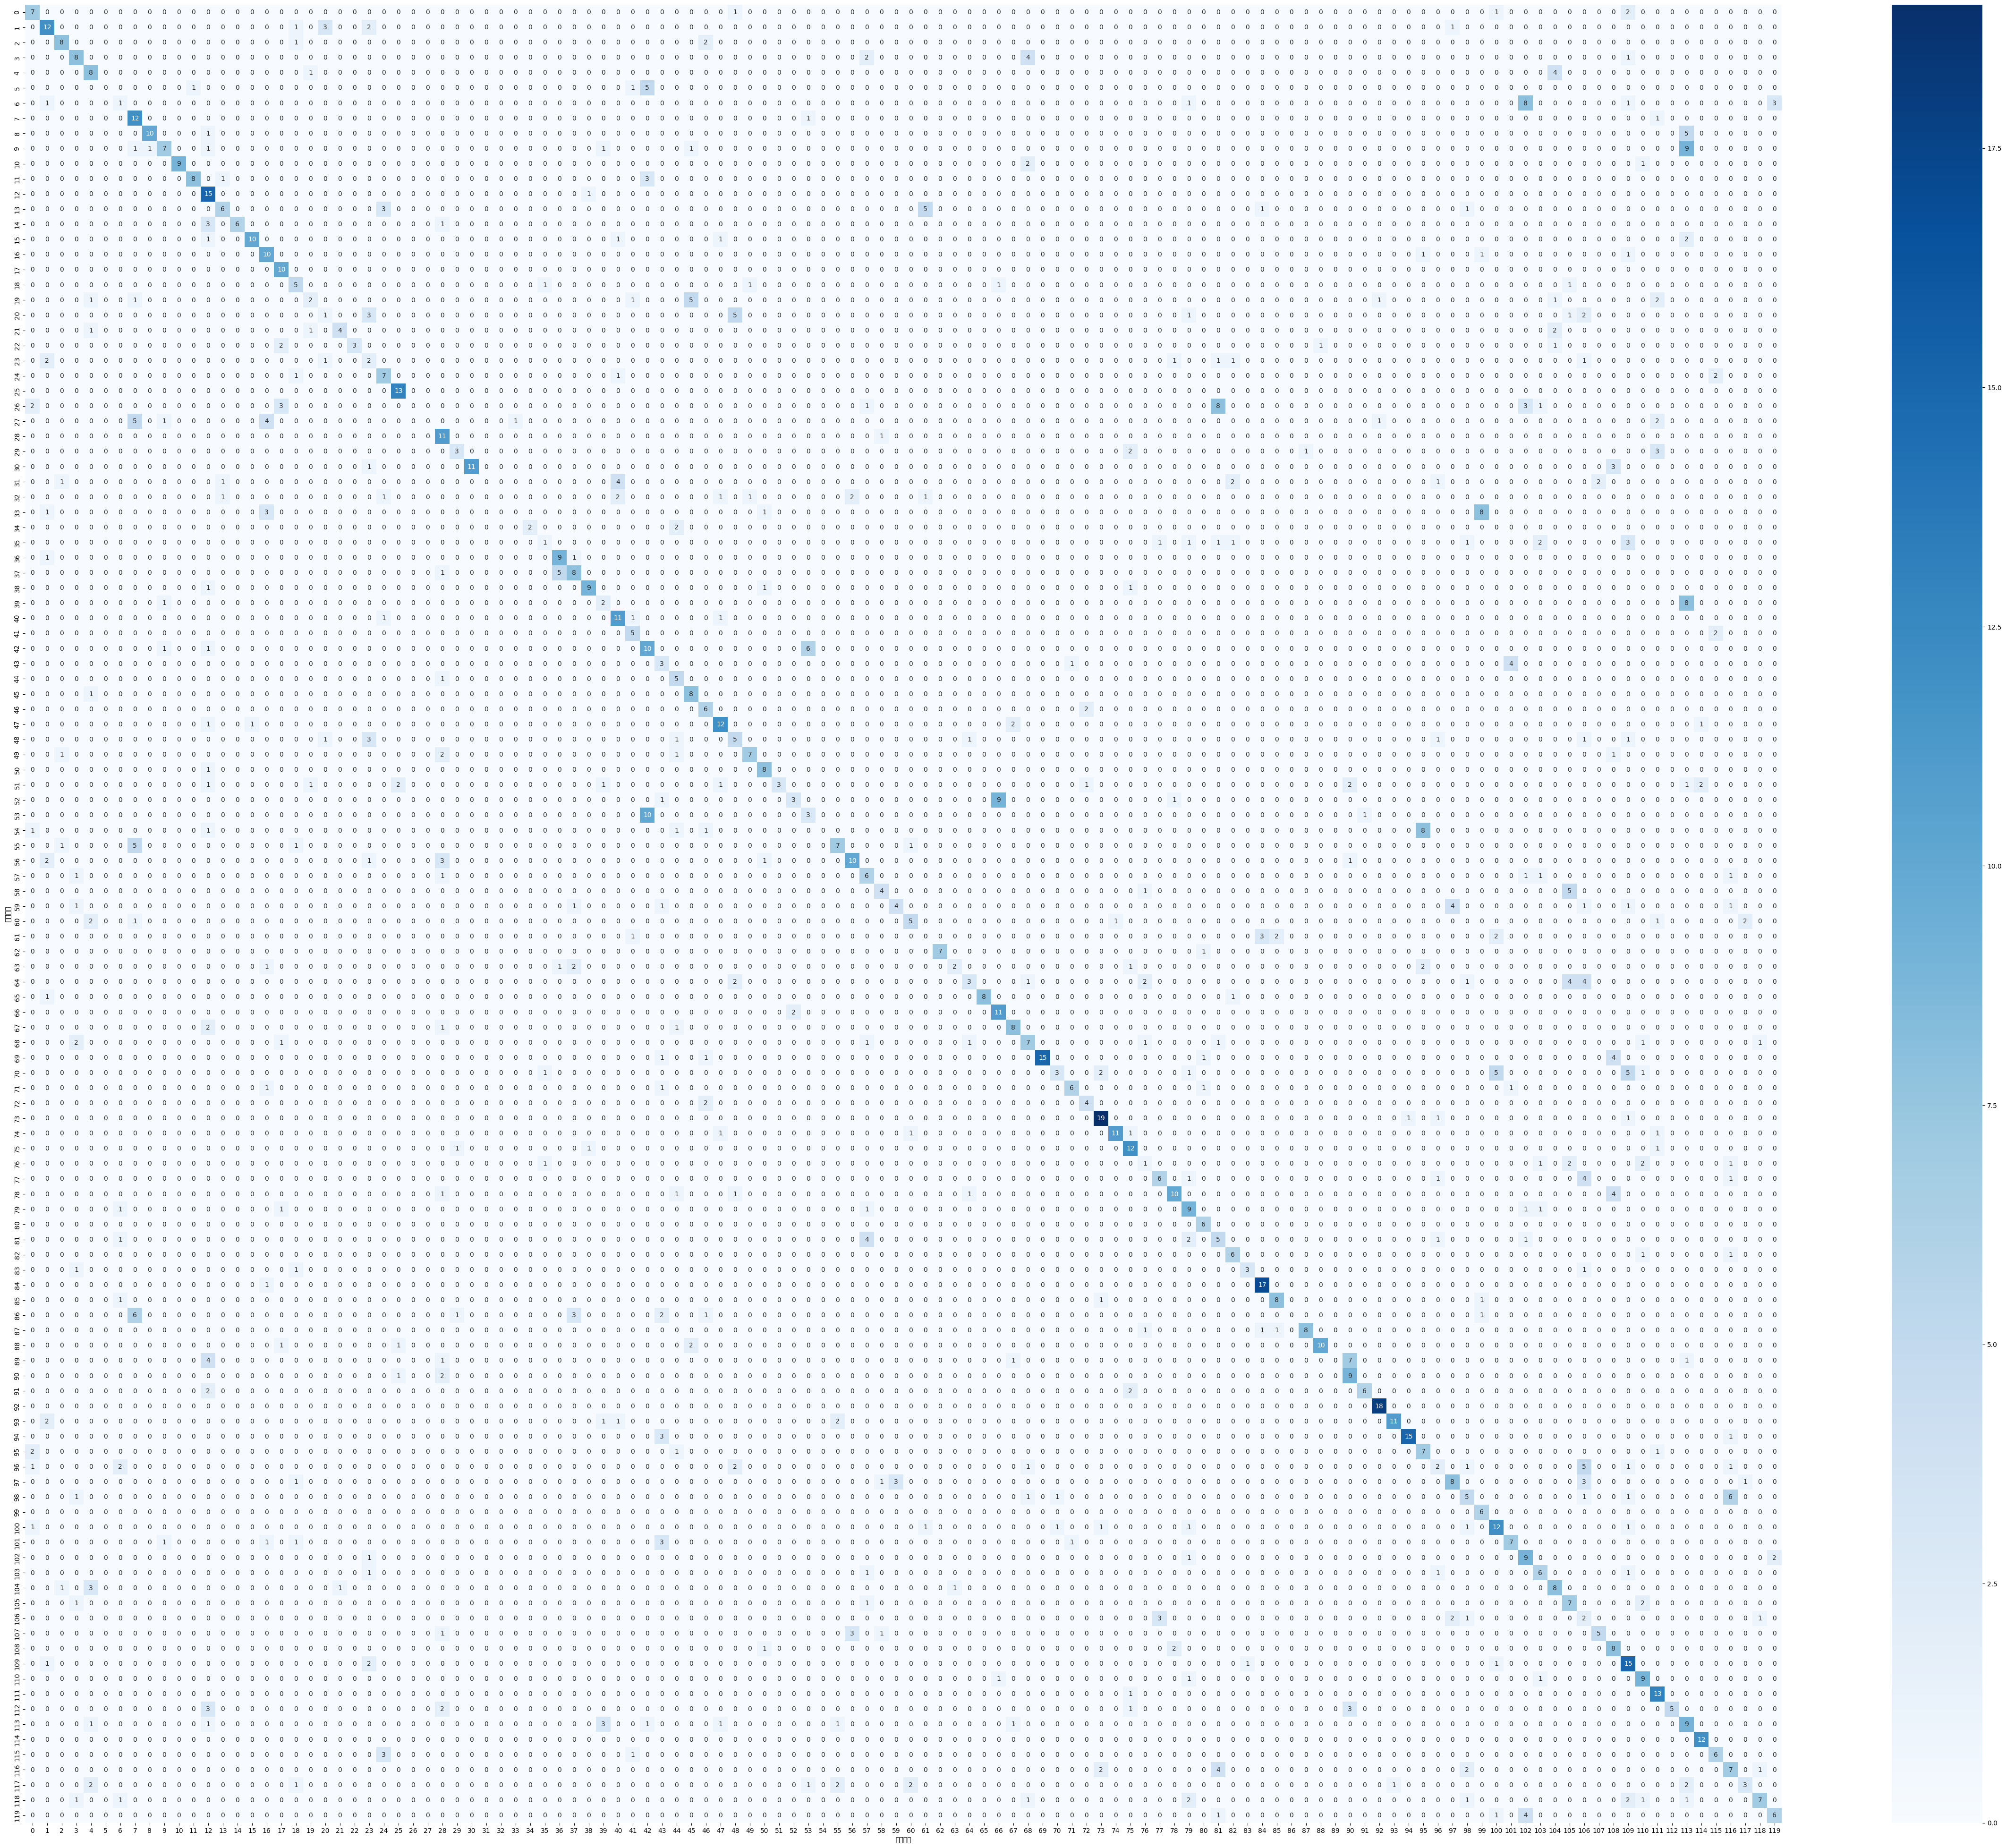

零样本准确率: 0.5303


In [ ]:
import torch
from transformers import CLIPModel, CLIPProcessor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
# ---- 1. 加载本地 HuggingFace CLIP ----
model_path = "/home/niedongliang/.cache/huggingface/clip-vit-b32"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPModel.from_pretrained(model_path).to(device)
processor = CLIPProcessor.from_pretrained(model_path)

# ---- 2. 创建文本提示 ----
def create_breed_prompts(breed_names):
    templates = [
        "a photo of a {}",
        "a picture of a {} dog",
        "an image of a {}",
        "a {} dog",
        "a cute {}",
        "a photo of the {} breed",
        "a dog of breed {}"
    ]
    return [t.format(name) for name in breed_names for t in templates]

breed_prompts = create_breed_prompts(labelnames)
num_templates = 7    # 模板数量

# ---- 3. 预计算文本特征 ----
@torch.no_grad()
def compute_text_features(model, prompts, device):
    inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
    text_features = model.get_text_features(**inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features

text_features = compute_text_features(model, breed_prompts, device)

print("文本特征形状：", text_features.shape)
# 应该是 [num_classes * 7, 512]

# ---- 4. 零样本预测 ----
@torch.no_grad()
def zero_shot_predict(model, images, text_features, num_classes, num_templates):
    # images 已经是 dataloader 的 normalized tensor
    images = images.to(device)

    # 直接用 HF 内部的 encode
    image_features = model.get_image_features(pixel_values=images)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    logits = image_features @ text_features.T
    probs = logits.softmax(dim=-1)

    probs = probs.reshape(len(images), num_classes, num_templates).mean(dim=-1)

    top5_values, top5_indices = probs.topk(5, dim=-1)
    return top5_indices.cpu().numpy(), top5_values.cpu().numpy()


# ---- 5. 评估准确率 ----
def evaluate_zero_shot(model, dataloader, text_features, labelnames, device):
    all_preds = []
    all_targets = []

    for images, targets in dataloader:
        preds, _ = zero_shot_predict(model, images, text_features,
                                     num_classes=len(labelnames),
                                     num_templates=7)
        all_preds.extend(preds[:, 0])  # top-1
        all_targets.extend(targets.numpy())
    plt.figure(figsize=(60,50))
    cm_rbf = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.savefig(f'none_finetuning_clip.png', dpi=300, bbox_inches='tight')
    plt.show()
    acc = sum(p == t for p, t in zip(all_preds, all_targets)) / len(all_targets)
    return acc, all_preds, all_targets

zero_shot_accuracy, val_preds, val_targets = evaluate_zero_shot(
    model, dataloaders['valid'], text_features, labelnames, device
)
print(f"零样本准确率: {zero_shot_accuracy:.4f}")


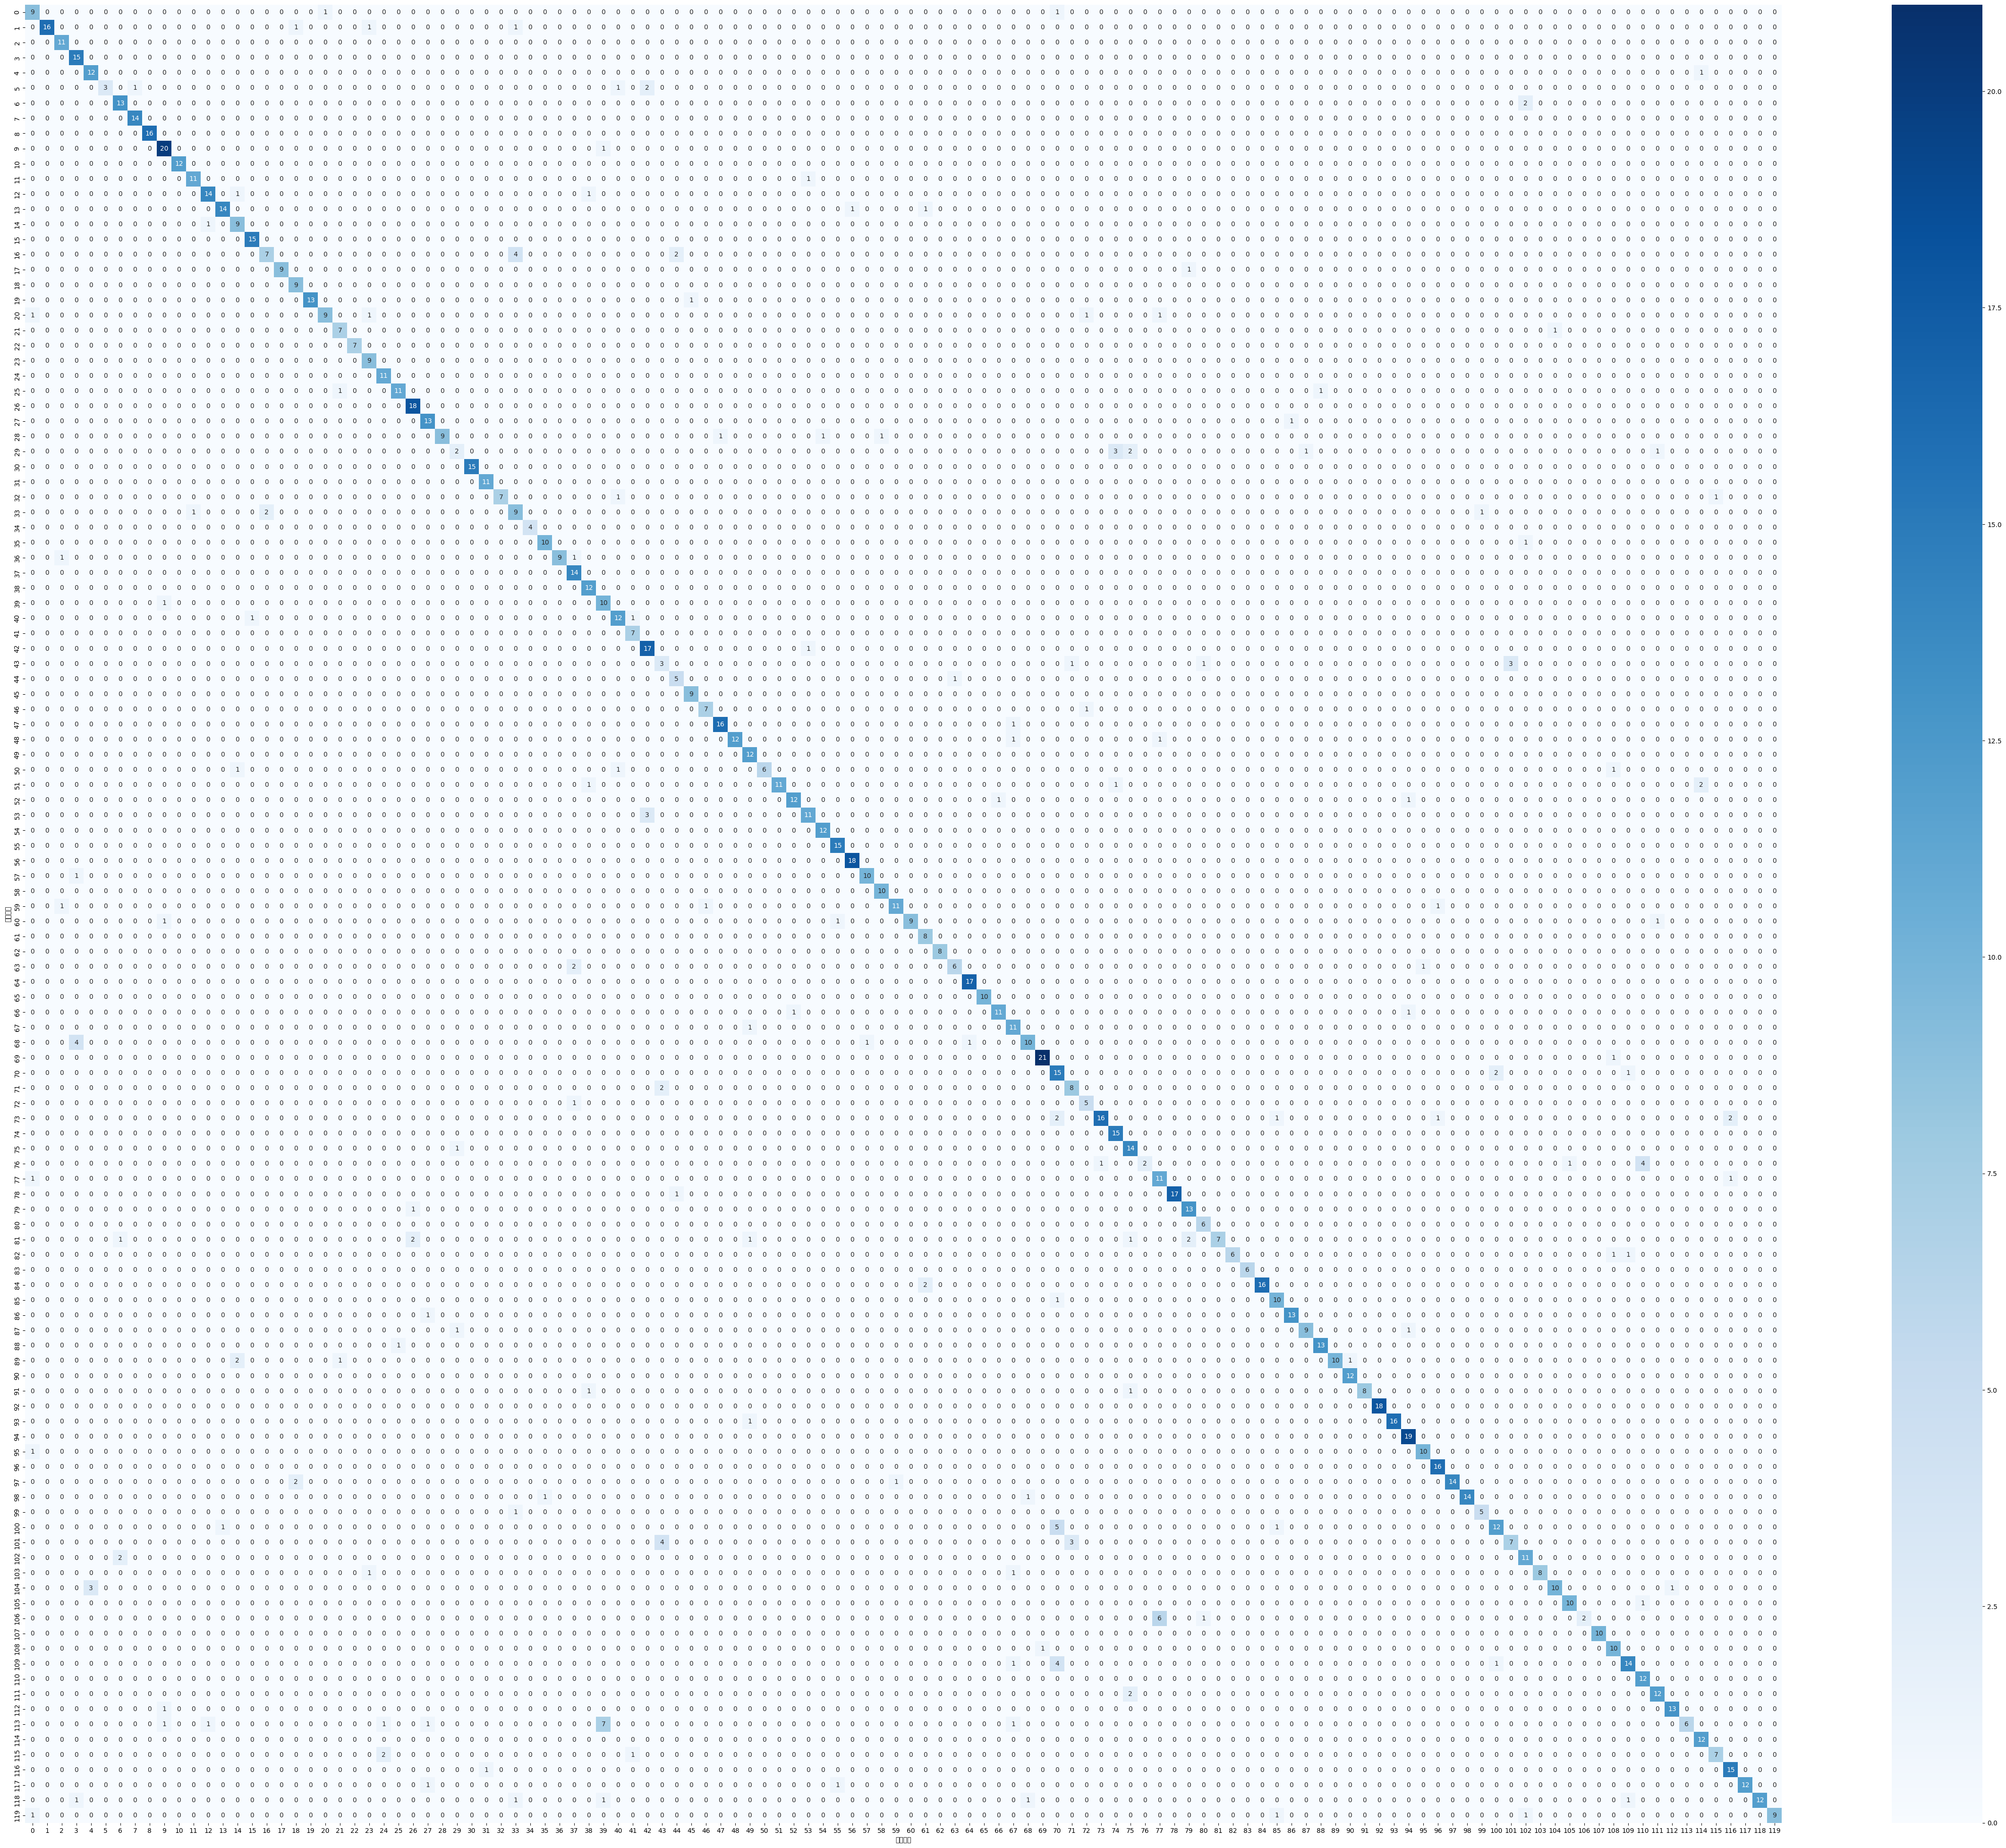

Soft Voting Ensemble ACC: 0.8571428571428571


In [41]:
import torch
import torch.nn.functional as F

class EnsembleSoftVoting(torch.nn.Module):
    def __init__(self, model1, model2, weight1=0.5, weight2=0.5):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.w1 = weight1
        self.w2 = weight2

    def forward(self, x):
        # 输出 logits
        logits1 = self.model1(x)
        logits2 = self.model2(x)

        # softmax 变成概率再加权
        probs1 = F.softmax(logits1, dim=1)
        probs2 = F.softmax(logits2, dim=1)

        # 加权融合
        final_probs = self.w1 * probs1 + self.w2 * probs2

        return final_probs

ensemble_model = EnsembleSoftVoting(resnet101, senet101, weight1=0.6, weight2=0.4)
ensemble_model.eval()

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def evaluate_ensemble_soft_vote(model, dataloader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_targets = []

    for images, targets in dataloader:
        images = images.to(device)
        targets = targets.to(device)
        # 前向传播（得到融合概率）
        probs = model(images)
        # top-1
        preds = probs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_targets.extend(targets.cpu().numpy().tolist())
    # 计算混淆矩阵
    plt.figure(figsize=(60, 50))
    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.savefig('ensemble_soft_vote.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 计算 ACC
    acc = sum(p == t for p, t in zip(all_preds, all_targets)) / len(all_targets)

    return acc, all_preds, all_targets


ensemble_model = EnsembleSoftVoting(resnet101, senet101, weight1=0.6, weight2=0.4)

acc, val_preds, val_targets = evaluate_ensemble_soft_vote(
    ensemble_model, 
    dataloaders['valid'], 
    device
)
print("Soft Voting Ensemble ACC:", acc)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        # 去掉 fc 层，只保留 conv1 → layer4
        self.features = nn.Sequential(*list(backbone.children())[:-1])  
        self.out_dim = backbone.fc.in_features

    def forward(self, x):
        x = self.features(x)  # [B, C, 1, 1]
        x = torch.flatten(x, 1)
        return x
class SENetFeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        # 去掉最后的 fc
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.out_dim = backbone.last_linear.in_features

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

class FeatureFusionEnsemble(nn.Module):
    """
    两个模型输出 feature，进行 concat 后接新的分类头
    """
    def __init__(self, feat_extractor1, feat_extractor2, num_classes):
        super().__init__()
        self.m1 = feat_extractor1
        self.m2 = feat_extractor2

        fusion_dim = feat_extractor1.out_dim + feat_extractor2.out_dim

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        f1 = self.m1(x)
        f2 = self.m2(x)

        fusion = torch.cat([f1, f2], dim=1)

        logits = self.classifier(fusion)
        return logits

    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm

@torch.no_grad()
def evaluate_feature_fusion(
    model, dataloader, device,
    save_feature_csv='fusion_features.csv',
    save_cm_path='fusion_cm.png'
):
    model.to(device)
    model.eval()

    all_targets = []
    all_preds = []
    all_feats = []

    for images, targets in tqdm(dataloader, desc='Fusion Ensemble Inference'):
        images = images.to(device)
        targets = targets.to(device)

        logits, fusion_feat = model(images)    # 获取融合特征

        preds = logits.argmax(dim=1)

        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_feats.append(fusion_feat.cpu().numpy())

    # 拼接所有特征
    all_feats = np.concatenate(all_feats, axis=0)
    print("融合特征维度:", all_feats.shape)

    # 保存 CSV
    df = pd.DataFrame(all_feats)
    df['target'] = all_targets
    df['pred'] = all_preds
    df.to_csv(save_feature_csv, index=False)
    print("Saved fusion features:", save_feature_csv)

    # 计算 ACC
    acc = np.mean(np.array(all_targets) == np.array(all_preds))

    # 混淆矩阵
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(60, 50))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.xlabel("Pred")
    plt.ylabel("Target")
    plt.savefig(save_cm_path, dpi=300, bbox_inches='tight')
    plt.show()

    return acc, all_preds, all_targets, all_feats


In [ ]:
resnet_feat = ResNetFeatureExtractor(resnet101)
senet_feat  = SENetFeatureExtractor(senet101)

fusion_model = FeatureFusionEnsemble(
    resnet_feat, 
    senet_feat, 
    num_classes=120
)
# 冻结所有特征提取层
for p in fusion_model.m1.parameters():
    p.requires_grad = False
for p in fusion_model.m2.parameters():
    p.requires_grad = False

# 只训练新加的分类头
for p in fusion_model.classifier.parameters():
    p.requires_grad = True
alexnet = models.alexnet(pretrained=True)
googlenet = models.googlenet(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
from models.SeResnet import se_resnext101
senet101=se_resnext101(pretrained="imagenet")

models_list=[alexnet,googlenet,resnet101,vgg16,densenet121,efficientnet_b0,mobilenet_v2,senet101,fusion_model]
train_losses_list,valid_losses_list,train_accuracies_list,valid_accuracies_list,models_name= multi_model_transfer_learning(models_list,25)

acc, preds, targets, fusion_feats = evaluate_feature_fusion(
    fusion_model,
    dataloaders['valid'],
    device,
    save_feature_csv='fusion_features.csv',
    save_cm_path='fusion_cm.png'
)
print("Fusion Ensemble ACC:", acc)

New classification layer moved to GPU
Model already exists, loading from ./model_weight/alexnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/googlenet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/resnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/vgg_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/densenet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/efficientnet_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exists, loading from ./model_weight/mobilenetv2_epoch25.pt
Model loaded successfully.
New classification layer moved to GPU
Model already exi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationLoss(nn.Module):
    """
    Knowledge Distillation Loss (Hinton)
    teacher_logits: 老师的 logits
    student_logits: 学生 logits
    target: ground truth
    T: 温度系数
    alpha: teacher 软标签所占权重
    """
    def __init__(self, T=4.0, alpha=0.7):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, target):
        # Hard Loss（学生对真实标签的 CE）
        hard_loss = self.ce(student_logits, target)

        # Soft Loss（学生 vs 教师 softmax 后的分布）
        soft_student = F.log_softmax(student_logits / self.T, dim=1)
        soft_teacher = F.softmax(teacher_logits / self.T, dim=1)

        soft_loss = F.kl_div(soft_student, soft_teacher, reduction="batchmean") * (self.T * self.T)

        # 总损失
        loss = self.alpha * soft_loss + (1 - self.alpha) * hard_loss
        return loss
import torch.nn as nn

teacher = senet101   # 你的 SENet 教师模型
student = alexnet    # 你的 AlexNet 学生模型

for p in teacher.parameters():
    p.requires_grad = False  # 冻结教师模型
teacher.eval()
def train_kd(student, teacher, dataloader, optimizer, device, num_epochs=10):
    kd_loss_fn = DistillationLoss(T=4.0, alpha=0.7)
    student.to(device)
    teacher.to(device)

    for epoch in range(num_epochs):
        student.train()
        teacher.eval()

        total_loss = 0
        correct = 0
        total = 0

        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)

            # Forward
            student_logits = student(images)
            with torch.no_grad():
                teacher_logits = teacher(images)

            # KD Loss
            loss = kd_loss_fn(student_logits, teacher_logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Student accuracy
            preds = student_logits.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {total_loss/len(dataloader):.4f}  ACC: {correct/total:.4f}")
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)

train_kd(student, teacher, dataloaders['train'], optimizer, device, num_epochs=25)